# A first simulation with Shyft

## Introduction
Shyft provides a toolbox for running hydrologic simulations. As it was designed to work in an operational environment, we've provided several different workflows for running a model simulation. The main concept to be aware of is that while we demonstrate and build on the use of a 'configuration', nearly all simulation functionality is also accessible with pure python through access to the `API`. This is the *encouraged* approach to simulation. The use of *configurations* is intended to be a mechanism of running repeated operational simulations when one is interested in archiving and storing (potentially to a database) the specifics of the simulation.

Below we start with a high level description using a configuration object, and in [Part II](advanced_simulation.ipynb) of the simulation notebooks we describe the approach using the lower level APIs. It is recommended, if you intend to use Shyft for any kind of hydrologic exploration, to become familiar with the API functionality.

### This notebook briefly runs through the simulation process for a pre-configured catchment. The following steps are described:
1. **Loading required python modules and setting path to Shyft installation**
2. **Configuration of a Shyft simulation**
3. **Running a Shyft simulation**
4. **Post-processing:** Fetching simulation results from the simulator-object.

## 1. Loading required python modules and setting path to SHyFT installation

Shyft requires a number of different modules to be loaded as part of the package. Below, we describe the required steps for loading the modules, and note that some steps are only required for the use of the jupyter notebook.

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
import datetime as dt
import pandas as pd
from os import path
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


### The Shyft Environment

This next step is highly specific on how and where you have installed Shyft. If you have followed the guidelines at github, and cloned the three shyft repositories: i) shyft, ii) shyft-data, and iii) shyft-doc, then you may need to tell jupyter notebooks where to find shyft. Uncomment the relevant lines below.

If you have a 'system' shyft, or used `conda install -s sigbjorn shyft` to install shyft, then you probably will want to make sure you have set the SHYFT_DATA directory correctly, as otherwise, Shyft will assume the above structure and fail. __This has to be done _before_ `import shyft`__. In that case, uncomment the relevant lines below.

**note**: it is most likely that you'll need to do one *or* the other.

In [2]:
# try to auto-configure the path, -will work in all cases where doc and data
# are checked out at same level
shyft_data_path = path.abspath("../../../shyft-data")
if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path
    
# shyft should be available either by it's install in python
# or by PYTHONPATH set by user prior to starting notebook.
# This is equivalent to the two lines below
#  shyft_path=path.abspath('../../../shyft')
#  sys.path.insert(0,shyft_path)

In [3]:
# once the shyft_path is set correctly, you should be able to import shyft modules

import shyft

# if you have problems here, it may be related to having your LD_LIBRARY_PATH
# pointing to the appropriate libboost_python libraries (.so files)
from shyft import api
from shyft.repository.default_state_repository import DefaultStateRepository
from shyft.orchestration.configuration.yaml_configs import YAMLSimConfig
from shyft.orchestration.simulators.config_simulator import ConfigSimulator

In [4]:
# now you can access the api of shyft with tab completion
# and help, try this:

# help(api.GeoPoint) # remove the hashtag and run the cell to print the documentation of the api.GeoPoint class

# remove the hashtag below, set the pointer behind the dot and use 
# tab completion to see the available attributes of the shyft api
#api

## 2. Configuration of a SHyFT simulation

The following shows how to set up a Shyft simulation using the `yaml_configs.YAMLSimConfig` class. Note that this is a **high level** approach, providing a working example for a simple simulation. More advanced users will want to eventually make use of direct API calls, as outlined in [Part II](advanced_simulation.ipynb).

At this point, you may want to have a look to the [configuration file](./nea-config/neanidelva_simulation.yaml) used in this example.

```
---
neanidelva:
  region_config_file: neanidelva_region.yaml
  model_config_file: neanidelva_model_calibrated.yaml
  datasets_config_file: neanidelva_datasets.yaml
  interpolation_config_file: neanidelva_interpolation.yaml
  start_datetime: 2013-09-01T00:00:00
  run_time_step: 86400  # 1 hour time step
  number_of_steps: 365  # 1 year
  region_model_id: 'neanidelva-ptgsk'
  #interpolation_id: 2   # this is optional (default 0)
  initial_state:
    repository:
      class: !!python/name:shyft.repository.generated_state_repository.GeneratedStateRepository
      params:
        model: !!python/name:shyft.api.pt_gs_k.PTGSKModel
    tags: []
...

```

The file is structured as follows:

`neanidelva` is the name of the simulation. Your configuration file may contain multiple "stanzas" or blocks of simulation configurations. You'll see below that we use the name to instantiate a configuration object.

`region_config_file` points to another yaml file that contains basic information about the region of the simulation. You can [explore that file here](./nea-config/neanidelva_region.yaml)

`model_config_file` contains the model parameters. Note that when you are calibrating the model, [this is the file](./nea-config/neanidelva_model_calibrated.yaml) that you would put your optimized parameters into once you have completed a calibrations.

`datasets_config_file` contains details regarding the input datasets and the [repositories](../../repositories.rst) they are contained in. You can see [this file here](./nea-config/neanidelva_datasets.yaml)

`interpolation_config_file` provides details regarding how the observational data in your catchment or region will be interpolated to the domain of the simulation. If you are using a repository with distributed data, the interpolation is still used. [See this file](./nea-config/neanidelva_interpolation.yaml) for more details.

The following:

```
  start_datetime: 2013-09-01T00:00:00
  run_time_step: 86400  # 1 hour time step
  number_of_steps: 365  # 1 year
  region_model_id: 'neanidelva-ptgsk'
```

are considered self-explantory. Note that `region_model_id` is simply a string name, but it should be **unique**. We will explain the details regarding `initial_state` later on in this tutorial.

In [5]:
# set up configuration using *.yaml configuration files
# here is the *.yaml file that configures the simulation:
config_file_path = os.path.abspath("./nea-config/neanidelva_simulation.yaml")
    
# and here we pass it to the configurator, together with the name of the region 
# stated in the simulation.yaml file (here: "neanidelva") which we would like to run
cfg = YAMLSimConfig(config_file_path, "neanidelva")

In [6]:
print(cfg)


YAMLSimConfig::neanidelva(_config_file='/home/sih/projects/shyft-doc/notebooks/nea-example/nea-config/neanidelva_simulation.yaml', config_dir='/home/sih/projects/shyft-doc/notebooks/nea-example/nea-config', _config_section='neanidelva', region_config_file='/home/sih/projects/shyft-doc/notebooks/nea-example/nea-config/neanidelva_region.yaml', model_config_file='/home/sih/projects/shyft-doc/notebooks/nea-example/nea-config/neanidelva_model.yaml', datasets_config_file='/home/sih/projects/shyft-doc/notebooks/nea-example/nea-config/neanidelva_datasets.yaml', interpolation_config_file='/home/sih/projects/shyft-doc/notebooks/nea-example/nea-config/neanidelva_interpolation.yaml', start_datetime=datetime.datetime(2013, 9, 1, 0, 0), run_time_step=86400, number_of_steps=364, region_model_id='neanidelva-ptgsk', initial_state={'repository': {'class': <class 'shyft.repository.generated_state_repository.GeneratedStateRepository'>, 'params': {'model': <class 'shyft.api.pt_gs_k._pt_gs_k.PTGSKModel'>}},

In [7]:
# Once we have all the configuration in place (read in from the .yaml files)
# we can start to do the simulation. Here we use the ConfigSimulator class 
# to initialize a simulator-object. Shyft has several ways to achieve this
# but the .yaml configs are the most straight forward

simulator = ConfigSimulator(cfg) 
# Now the simulator is ready to run!

### The simulator and the region_model
It is important to note that the simulator provides a wrapping of underlying API functionality. It is designed to provide a quick and simple interface for conducting runs based on a configuration saved in a `.yaml` file, or otherwise. Core functionality is contained in the [region_model](../../region_model.rst). This is an import concept in Shyft. To understand the framework, one should be familiar with this class. 


Before we begin the simulation, one should explore the `simulator` object with tab completion. As an example, you can see here how to get the number of cells in the region that was set up. This is used later for extracting the data.

Most importantly, the simulator as an attribute called `region_model`. Most of the underlying functionality of the `simulator` methods are actually making calls to the `region_model` class. To conduct more advanced simulations one would use this object directly.

In [8]:
#simulator.  #try tab completion
n_cells = simulator.region_model.size()
print(n_cells)

3874


In [9]:
c0 = simulator.region_model.cells[0]
type(c0)

shyft.api.pt_gs_k._pt_gs_k.PTGSKCellAll

## 3. Running a SHyFT simulation

Okay, so thus far we have set up our `cfg` object which contains most the information required to run the simulation. We can simply run the simulation using the `run` method.

In [10]:
simulator.run()

/home/sih/projects/miniconda/envs/shyft_env/lib/python3.6/site-packages/shyft/repository/netcdf/utils.py:347: RuntimeWarning: invalid value encountered in greater
  pure_arr = nc_var[data_slice][xy_slice_mask]


Running simulation...


In [11]:
simulator.initial_state_repo


But this is may be too simple. Let's explore the `simulator.run` method a bit further:

In [12]:
help(simulator.run)

Help on method run in module shyft.orchestration.simulator:

run(time_axis=None, state=None) method of shyft.orchestration.simulators.config_simulator.ConfigSimulator instance
    Forward simulation over time axis
    
    Parameters
    ----------
    time_axis: shyft.api.TimeAxis
        Time axis defining the simulation period, and step sizes.
    state: shyft.api state



Note that you can pass two parameters to `run`. To run a simulation, we need a time_axis (length of the simulation), and an initial state. Initially we got both of these from the `cfg` object (which takes it from the .yaml files). However, in some cases you will likely want to change these and conduct simulations for different periods, or starting from different states. We explore this further in [Part II: advanced simulation](./advanced_simulation.ipynb)

## 4. Post processing and data extraction

You have now completed a simple simulation. You probably are interested to explore some of the output from the simulation and to visulize the quality of the results. Let's explore first, how to access the underlying data produced from the simulation.


### Visualizing the discharge for each [sub-]catchment
Recall that we earlier referred to the importance of understanding the `region_model`. You'll see now that this is where information from the simulation is actually contained, and that the `simulator` object is more or less a convenience wrapper.

In [13]:
# Here we are going to extact data from the simulator object.
# We start by creating a list to hold discharge for each of the subcatchments.
# Then we'll get the data from the simulator object

# mapping of internal catch ID to catchment
catchment_id_map = simulator.region_model.catchment_id_map 
print(catchment_id_map)

[1228, 1308, 1330, 1394, 1443, 1726, 1867, 1966, 1996, 2041, 2129, 2195, 2198, 2277, 2402, 2446, 2465, 2545, 2640, 2718, 2728, 3002, 3178, 3536, 3630, 1000010, 1000011]


We see here that each sub-catchment in our simulation is associated with a unique ID. These are user defined IDs. In the case of the nea-nidelva simulation, they are taken from the GIS database used to create the example configuration files.

To get data out of the `region_model` you need to specify which catchments you are interested in evaluating. In the following example we are going to extract the data for each catchment and make a simple plot.

Note that Shyft uses many specialized C++ types. Many of these have methods to convert to the more familiar `numpy` objects. An example may be the discharge timeseries for a catchment.

In [14]:
q_1228_ts = simulator.region_model.statistics.discharge([1228])
q_1228_np = simulator.region_model.statistics.discharge([1228]).values.to_numpy()
print(type(q_1228_ts))
print(type(q_1228_np))

<class 'shyft.api._api.TimeSeries'>
<class 'numpy.ndarray'>


`shyft.api._api.Timeseries` objects have a lot more functionality, but we'll cover that in a separate tutorial.

For now we'll work in a 'pythonic' and simple way a convert all our data to python types. To do this, we'll use the [Pandas](https://www.pandas.org) library. But note also that we'll have to do some list magic to get the timeseries and datetime values out.

Text(0,0.5,'discharge [m3 s-1]')

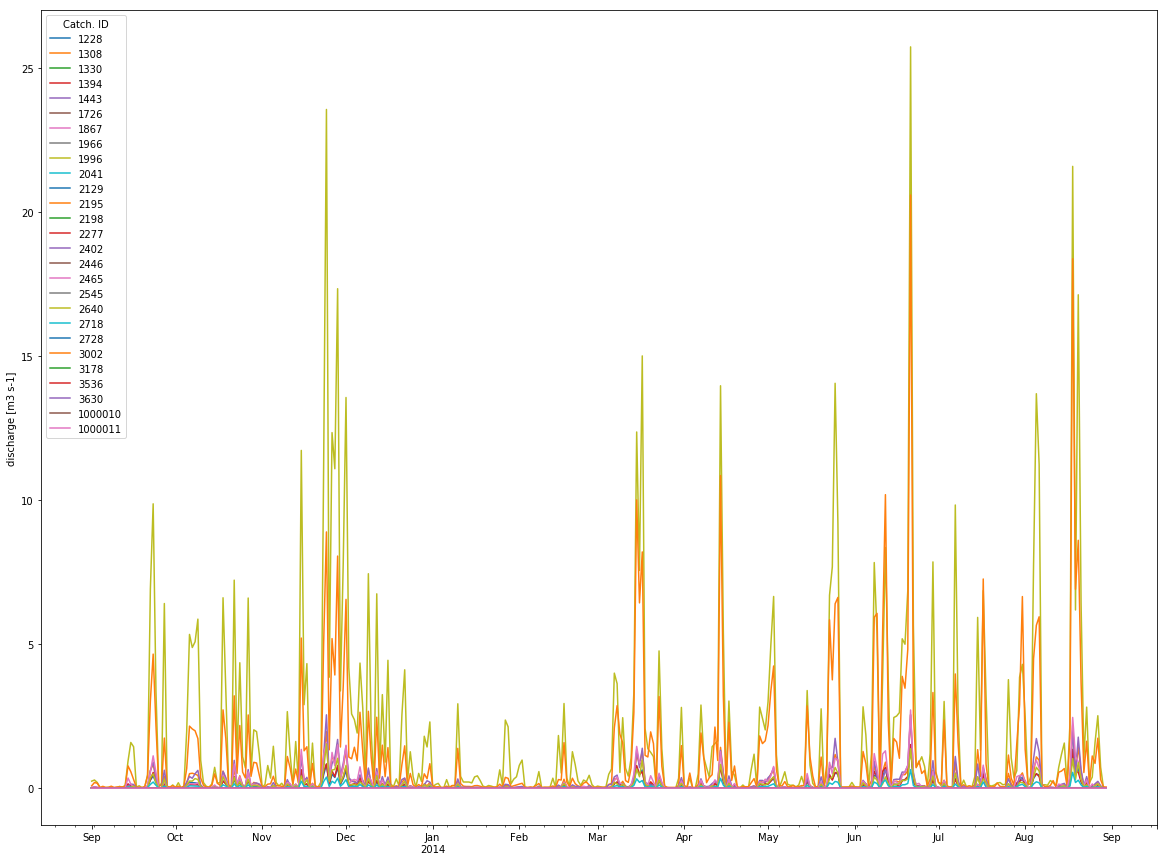

In [15]:
# First get the time-axis which we'll use as the index for the data frame
ta = simulator.region_model.time_axis
# and convert it to datetimes
index = [dt.datetime.utcfromtimestamp(p.start) for p in ta]

# Now we'll add all the discharge series for each catchment 
data = {}
for cid in catchment_id_map:
    # get the discharge time series for the subcatchment
    q_ts = simulator.region_model.statistics.discharge([int(cid)])
    data[cid] = q_ts.values.to_numpy()

df = pd.DataFrame(data, index=index)
# we can simply use:
ax = df.plot(figsize=(20,15))
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

#### A preferred approach
As mentioned above, Shyft has it's own Timeseries class. This class is quite powerful, and in [future tutorials](../../future_tutorials.rst) we'll explore more of the functionality. For now, let's look at some key aspects, and how to create the same plot as above without pandas.


In [16]:
# api.TsVector() is a list of api.Timeseries type. 
discharge_ts = api.TsVector() #  except from the type, it just works as a list()
# loop over each catchment, and extract the time-series (we keep them as such for now)
for cid in catchment_id_map: # fill in discharge time series for all subcatchments
    discharge_ts.append(simulator.region_model.statistics.discharge([int(cid)]))
    # discharge is a TS object,keeping a .time_axis and .values

Text(0,0.5,'discharge [m3 s-1]')

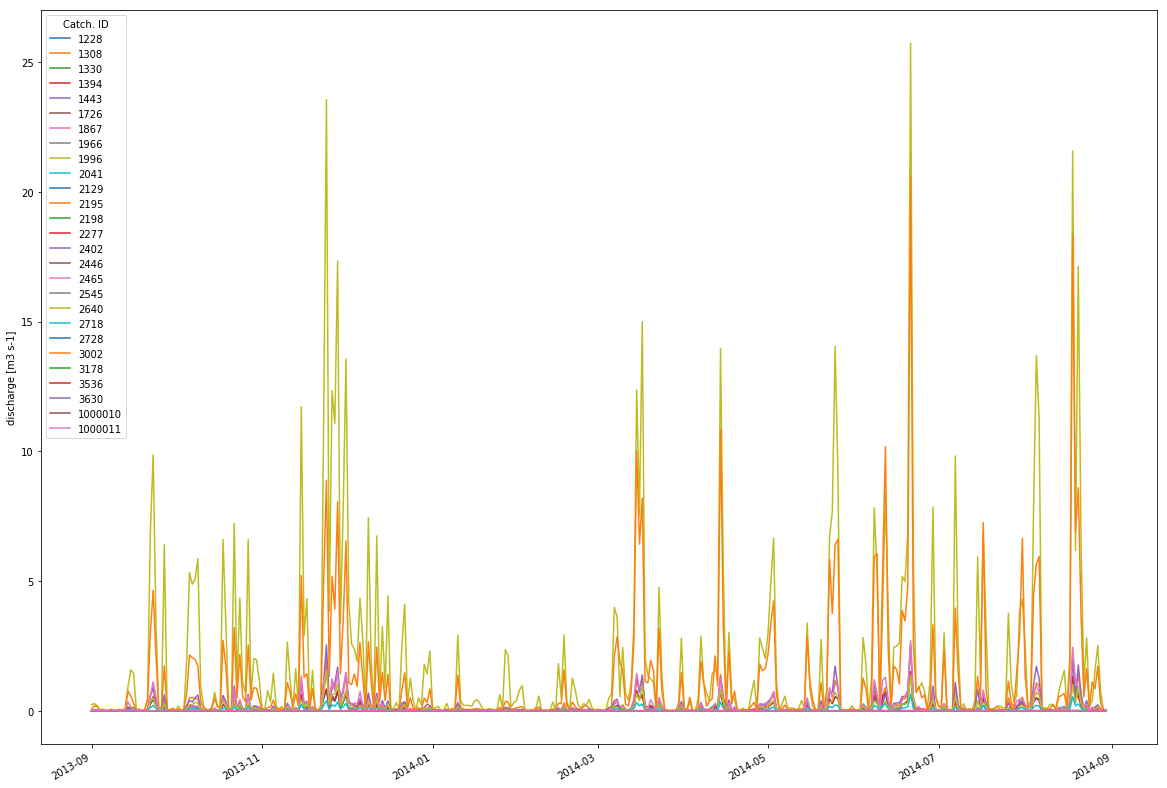

In [17]:
# We can make a quick plot of the data of each sub-catchment
fig, ax = plt.subplots(figsize=(20,15))

# plot each catchment discharge in the catchment_id_map
for i,ts in enumerate(discharge_ts):
    # a ts.time_axis can be enumerated to it's UtcPeriod, 
    # that will have a .start and .end of type utctimestamp
    # to use matplotlib support for datetime-axis, we convert it to datetime (as above)
    ts_timestamps = [datetime.datetime.utcfromtimestamp(p.start) for p in ts.time_axis]
    ts_values = ts.values # iterable and convertible, .to_numpy() makes an np array
    ax.plot(ts_timestamps,ts_values, label = "{}".format(catchment_id_map[i]))
fig.autofmt_xdate()
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

#### A teaser to the Shyft API
The Shyft API, `shyft.api` contains a lot of functionality worth exploring.

As we mentioned, the `api.Timeseries` class provides some tools for adding timeseries, looking at statistics, etc. Below is a quick exploration of some of the possibilities. Users should explore using the source code, tab completion, and most of all `help` to get the full 
story...

Text(0,0.5,'discharge [m3 s-1]')

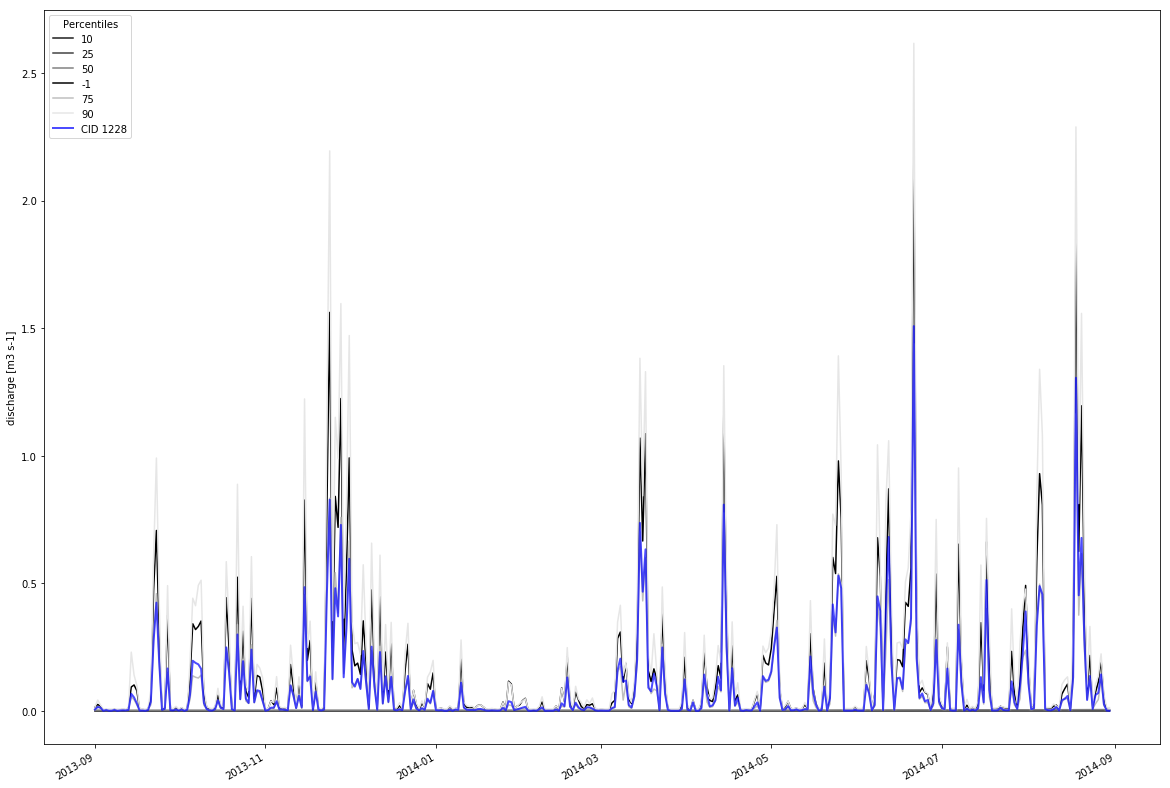

In [18]:
# First, we can also plot the statistical distribution of the 
# discharges over the sub-catchments

# get the percentiles we want, note -1 = arithmetic average
percentiles= api.IntVector([10,25,50,-1,75,90])  

# create a Daily(for the fun of it!) time-axis for the percentile calculations
# (our simulation could be hourly) 
ta_statistics = api.TimeAxis(simulator.region_model.time_axis.time(0),api.Calendar.DAY,365)

# then simply get out a new set of time-series, corresponding to the percentiles we specified
# note that discharge_ts is of the api.TsVector type, not a simple list as in our first example above
discharge_percentiles = api.percentiles(discharge_ts,ta_statistics,percentiles)

#utilize that we know that all the percentile time-series share a common time-axis
common_timestamps = [datetime.datetime.utcfromtimestamp(p.start) for p in ta_statistics] 

# Then we can make another plot of the percentile data for the sub-catchments
fig, ax = plt.subplots(figsize=(20,15))

# plot each discharge percentile in the discharge_percentiles
for i,ts_percentile in enumerate(discharge_percentiles):
    clr='k'
    if percentiles[i] >= 0.0: 
        clr= str(float(percentiles[i]/100.0))
    ax.plot(common_timestamps, ts_percentile.values, label = "{}".format(percentiles[i]),color=clr)

# also plot catchment discharge along with the statistics
# notice that we use .average(ta_statistics) to properly align true-average values to time-axis
ax.plot(common_timestamps,discharge_ts[0].average(ta_statistics).values,label = "CID {}".format(catchment_id_map[0]),linewidth=2.0,alpha=0.7,color='b')

fig.autofmt_xdate()
ax.legend(title="Percentiles")
ax.set_ylabel("discharge [m3 s-1]")

In `shyft.orchestration` there are other functions for exploring the data. We've created a function that creates the plot above.

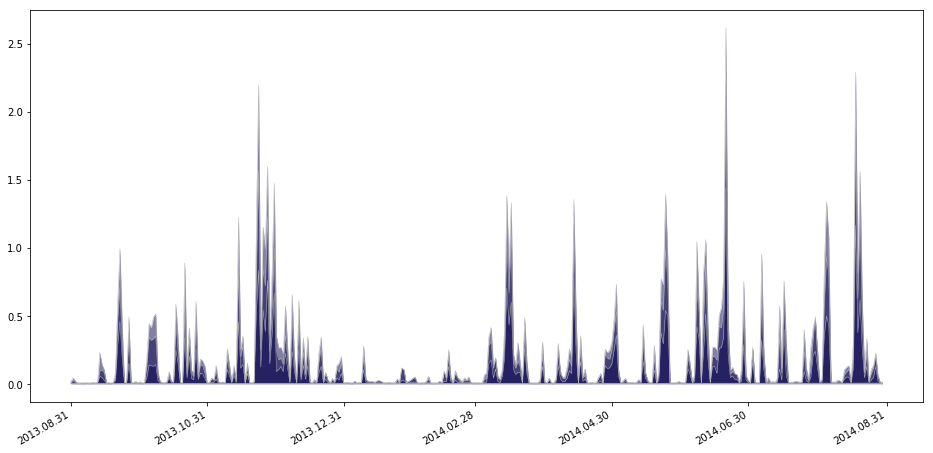

In [19]:
# a simple percentile plot, from orchestration looks nicer
from shyft.orchestration import plotting as splt
oslo=api.Calendar('Europe/Oslo')  # notice that we use olson tz-id to select time-zone
fig,ax=plt.subplots(figsize=(16,8))
splt.set_calendar_formatter(oslo) # notice how easy it is to ensure timestamp labels are tz aware
h,ph=splt.plot_np_percentiles(common_timestamps,[ p.values.to_numpy() for p in discharge_percentiles],base_color=(0.03,0.01,0.3))

### Visualizing the distributed catchment data

An important, but difficult concept, to remember when working with Shyft, is that internally there is no 'grid' to speak of. The simulation is vectorized, and each 'cell' represents a spatial area with it's own area and geolocation information. Therefore, we cannot just load a datacube of data, as some may be familiar with.

Visualization of this data is a bit more complex, because each individual cell is in practice an individual polygon. Depending on how the data has been configured for Shyft (see [region_model](../../region_model.rst)), the cells may, in fact, be simple squares or more complex shapes. For the visualization below, we simply treat them as uniform size, and plot them with the `scatter` function in matplotlib.

#### Extract data for individual simulation cells
We'll start by looking at values of individual cells, rather than at the catchment level. Since Shyft does not have an underlying 'raster' model, you need to fetch all cells directly from the underlying `region_model`.

In [20]:
cells = simulator.region_model.get_cells()

# Once we have the cells, we can get their coordinate information
# and fetch the x- and y-location of the cells
x = np.array([cell.geo.mid_point().x for cell in cells])
y = np.array([cell.geo.mid_point().y for cell in cells])

We also will need to get a 'z' value to make things interesting. Since this is the first time we've visualized our catchment, let's make a map of the sub-catchments. To do this, the first thing we need to do is get the membership of each cell. That is, to which catchment does it below. We do this by extracting the `catchment_id` of each cell -- and this is what we'll map. The result will be a map of the sub-catchments.

Recall from above we extracted the `catchment_id_map` from the `region_model`:
    
    # mapping of internal catch ID to catchment
    catchment_id_map = simulator.region_model.catchment_id_map 

We could just use the `catchment_id` as the 'z' value, but since this could be a string, we'll take a different approach. We'll assign a unique integer to each `catchment_id` and plot those (it is also easier for the color bar scaling).

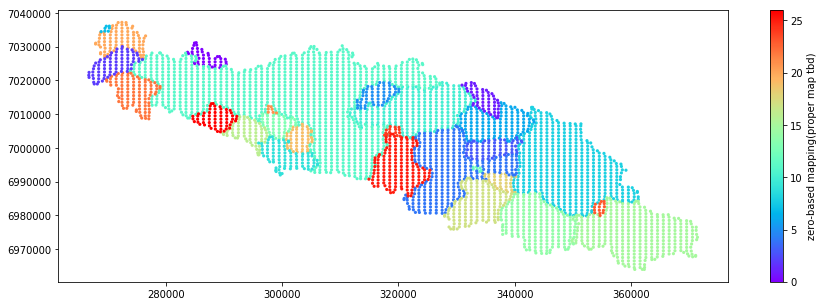

In [21]:
# let's create the mapping of catchment_id to an integer:
cid_z_map = dict([ (catchment_id_map[i],i) for i in range(len(catchment_id_map))])

# then create an array the same length as our 'x' and 'y', which holds the
# integer value that we'll use for the 'z' value
catch_ids = np.array([cid_z_map[cell.geo.catchment_id()] for cell in cells])

# and make a quick catchment map...
# using a scatter plot of the cells
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('rainbow')
plot = ax.scatter(x, y, c=catch_ids, marker='.', s=40, lw=0, cmap=cm)
plt.colorbar(plot).set_label('zero-based mapping(proper map tbd)')

### Visualing the Snow Cover Area of all cells for a certain point in time
Here we'll do some more work to look at a snapshot value of data in each of the cells. This example is collecting the response variable (here the Snow Cover Area (SCA)) for each of the cells for a certain point of time.

The "response collector" is another concept within Shyft that is important keep in mind. We don't collect and store responses for every variable, in order to keep the simulation memory use lean. Therefore, depending on your application, it may be required to explicitly enable this. The relevant code is found in `region_model.h` in the C++ core source code.

For the `ConfigSimulator` class, which we used to instantiate the `simulator`, a standard collector is used that will provide access to the most relevant variables.

For a model run during calibration, we are use a collector that just does the required minimum for the calibration. And, it is still configurable: we can turn on/off the snow-collection, so if we don't calibrate for snow, they are not collected. More on calibration is shown in the tutorial: [Calibration with Shyft](calibrate_nea_nidelva.ipynb)

The state collector used for the 'highspeed' calibration models (C++), is a null-collector, so no memory allocated, and no cpu-time used.


In [22]:
#first, set a date: year, month, day, (hour of day if hourly time step)
oslo = api.Calendar('Europe/Oslo') # specifying input calendar in Oslo tz-id
time_x = oslo.time(2014,5,15)  # the oslo calendar(incl dst) converts calendar coordinates Y,M,D.. to its utc-time

# we need to get the index of the time_axis for the time
try:
    idx = simulator.region_model.time_axis.index_of(time_x) # index of time x on time-axis
except:
    print("Date out of range, setting index to 0")
    idx = 0

# fetching SCA (the response variable is named "snow_sca")
# You can use tab-completion to explore the `rc`, short for "response collector"
# object of the cell, to see further response variables available.
# specifying empty list [] indicates all catchments, otherwise pass catchment_id
sca = simulator.region_model.gamma_snow_response.sca([],idx)

Let's take a closer look at this... 

    simulator.region_model.time_axis.index_of(time_x)
   
Simply provided an index value that we can use to index the cells for the time we're interested in looking at.

Next we use:

    simulator.region_model.gamma_snow_response
    
What is this? This is a collector from the simulation. In this case, for the `gamma_snow` routine. It contains a convenient method to access the response variables from the simulation on a per catchment level. Each response variable (`outflow`, `sca`, `swe`) can be called with two arguments. The first a list of the catchments, and the second an index to the time, as shown above. Note, this will return the values for each cell in the sub-catchment. Maybe one is only interested in the total `outflow` or total `swe` for the region. In this case you can use: `.outflow_value` which will return a single value.

There is also a response collector for the state variables: `.gamma_snow_state`. 

Explore both of these further with tab completion or `help`. As well as the full `region_model` to see what other algorithm collectors are available as this example is configured.

In [23]:
# for attr in dir(simulator.region_model):
#     if attr[0] is not '_': #ignore privates
#         print(attr)
# # and don't forget:
# help(simulator.region_model.gamma_snow_state)

We are now ready to explore some of the variables from the simulation. We'll continue on with SCA. 

Text(0.5,1,'Snow Covered area of neanidelva-ptgsk on 2014-05-15T00:00:00+02')

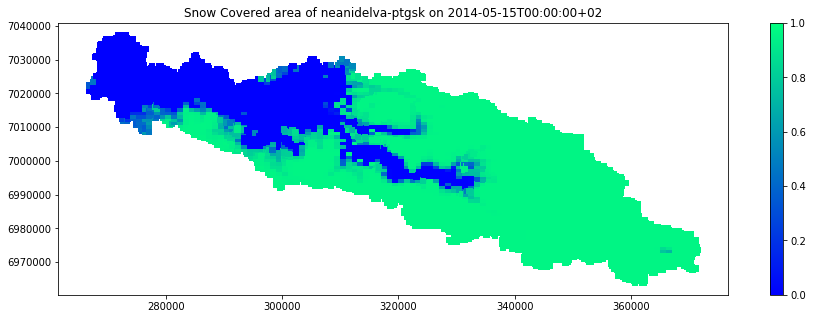

In [24]:
# We can make a simple scatter plot again for quick visualization
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('winter')
plot = ax.scatter(x, y, c=sca, 
                  vmin=0, vmax=1, 
                  marker='s', s=40, lw=0, 
                  cmap=cm)
plt.colorbar(plot)
plt.title('Snow Covered area of {0} on {1}'.format(cfg.region_model_id, oslo.to_string(time_x)))

#### A note about the geometry of the region
Again, keep in mind that while we have created a variable that contains the values for `sca` in each cell, this is only an iterable object. The only reason we know where each value is located is because we have corresponding `x` and `y` values for each cell. It is not an array.

We can calculate some statistics directly out of `sca`:

Average SCA for Nea Nidelva: 0.6771728705105866


Text(0,0.5,'frequency')

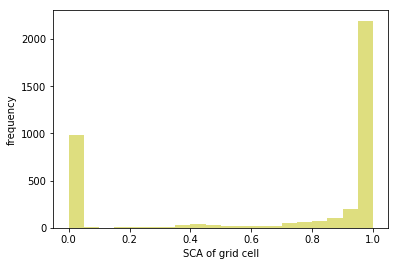

In [25]:
# look at the catchment-wide average:
nea_avg_sca = np.average(sca)
print("Average SCA for Nea Nidelva: {0}".format(nea_avg_sca))

# And let's compute histogram of the snow covered area as well
fig, ax = plt.subplots()
ax.hist(sca, bins=20, range=(0,1), color='y', alpha=0.5)
ax.set_xlabel("SCA of grid cell")
ax.set_ylabel("frequency")